# Imports

In [1]:
from scripts.extract import convert_xml_to_dataframe
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Input, Dense, Normalization
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from datetime import datetime

import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import wandb
from wandb.keras import WandbCallback

wandb.login(key="50fdec0adbfaf9ef335c8ec6c0446e412c23a452")
wandb.init(project="parodontitis", entity="krokante-krab")

wandb.config = {
    'method': "bayes",
    'metric': {
        'name': 'loss',
        'goal': 'minimize',
    },
    'parameters': {
        "optimizer": {
            "values": ['adam', 'sgd']
        },
        "nodes": {
            "values": [64, 128, 256, 512, 1024]
        },
        "epochs": {
            'max': 30, 'min': 10
        },
        "learning_rate": {
            'max': 0.01, 'min': 0.00001
        },
        "batch_size": {
            'values': [16, 32, 64]
        },
        "layers": {
            'max': 6, 'min': 1
        },
        'dropout': {
            'values': [0.3, 0.4, 0.5]
        },
    },
}

wandb: Currently logged in as: tim-avans (krokante-krab). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Tim/.netrc


In [3]:
RANDOM_STATE = 1

# Load data

In [4]:
# df = convert_xml_to_dataframe()
df = pd.read_csv('../data/patients.csv')

X = df[[
    # 'PATIENT_ID',
    # 'SEX',
    # 'BIRTH_DATE',
    # 'VISIT_DATE',
    # 'TREATING_PROVIDER',
    'BLEEDING_ON_PROBING',
    'NR_OF_POCKET',
    'NR_OF_FURCATION',
    'NR_OF_MOBILITY',
    'TOTAL_LOSS_OF_ATTACHMENT_LEVEL'
]]

y = df[[
    'HAS_PARODONTITIS'
]]
# df.head()

# Split train and test data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)

In [6]:
y_train_without_parodontitis = y_train[y_train["HAS_PARODONTITIS"] == 0]
y_test_without_parodontitis = y_test[y_test["HAS_PARODONTITIS"] == 0]

print(f'y_train: {(100/len(y_train)) * len(y_train_without_parodontitis)}% without parodontitis')
print(f'y_test: {(100/len(y_test)) * len(y_test_without_parodontitis)}% without parodontitis')

y_train: 66.27142857142857% without parodontitis
y_test: 66.27790736421193% without parodontitis


# Normalization

In [7]:
normalizer = Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

# Training

In [8]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    normalizer,
    Dense(10, activation='softmax'),
    # Dense(, activation='softmax'),
    Dense(2, activation='softmax')
])

model.compile(Adam(learning_rate=0.01), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 93
Trainable params: 82
Non-trainable params: 11
_________________________________________________________________


In [9]:
history = model.fit(X_train, y_train, epochs=15, validation_split=0.1, validation_data=(X_test, y_test), callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/15
196/219 [=========================>....] - ETA: 0s - loss: 0.2017 - accuracy: 0.9609INFO:tensorflow:Assets written to: C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best)... Done. 0.0s


219/219 [==============================] - 2s 9ms/step - loss: 0.1855 - accuracy: 0.9643 - val_loss: 0.0365 - val_accuracy: 0.9953
Epoch 2/15
198/219 [==========================>...] - ETA: 0s - loss: 0.0239 - accuracy: 0.9964INFO:tensorflow:Assets written to: C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best)... Done. 0.0s


219/219 [==============================] - 2s 7ms/step - loss: 0.0230 - accuracy: 0.9966 - val_loss: 0.0120 - val_accuracy: 0.9983
Epoch 3/15
199/219 [==========================>...] - ETA: 0s - loss: 0.0102 - accuracy: 0.9986INFO:tensorflow:Assets written to: C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best)... Done. 0.0s


219/219 [==============================] - 1s 6ms/step - loss: 0.0101 - accuracy: 0.9986 - val_loss: 0.0062 - val_accuracy: 0.9997
Epoch 4/15
206/219 [===========================>..] - ETA: 0s - loss: 0.0060 - accuracy: 0.9991INFO:tensorflow:Assets written to: C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best)... Done. 0.0s


219/219 [==============================] - 1s 7ms/step - loss: 0.0059 - accuracy: 0.9991 - val_loss: 0.0038 - val_accuracy: 0.9997
Epoch 5/15
191/219 [=========================>....] - ETA: 0s - loss: 0.0034 - accuracy: 0.9995INFO:tensorflow:Assets written to: C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best)... Done. 0.0s


219/219 [==============================] - 1s 6ms/step - loss: 0.0038 - accuracy: 0.9993 - val_loss: 0.0030 - val_accuracy: 0.9997
Epoch 6/15
213/219 [============================>.] - ETA: 0s - loss: 0.0028 - accuracy: 0.9997INFO:tensorflow:Assets written to: C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best)... Done. 0.0s


219/219 [==============================] - 1s 6ms/step - loss: 0.0028 - accuracy: 0.9997 - val_loss: 0.0019 - val_accuracy: 0.9997
Epoch 7/15
199/219 [==========================>...] - ETA: 0s - loss: 0.0021 - accuracy: 0.9997INFO:tensorflow:Assets written to: C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best)... Done. 0.0s


219/219 [==============================] - 1s 7ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 0.0014 - val_accuracy: 0.9997
Epoch 8/15
218/219 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 0.9997INFO:tensorflow:Assets written to: C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best)... Done. 0.0s


219/219 [==============================] - 1s 7ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 9/15
211/219 [===========================>..] - ETA: 0s - loss: 0.0013 - accuracy: 0.9997INFO:tensorflow:Assets written to: C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best)... Done. 0.0s


219/219 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 9.0632e-04 - val_accuracy: 1.0000
Epoch 10/15
197/219 [=========================>....] - ETA: 0s - loss: 9.6503e-04 - accuracy: 0.9998INFO:tensorflow:Assets written to: C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best)... Done. 0.0s


219/219 [==============================] - 1s 6ms/step - loss: 9.2259e-04 - accuracy: 0.9999 - val_loss: 6.6726e-04 - val_accuracy: 1.0000
Epoch 11/15
200/219 [==========================>...] - ETA: 0s - loss: 8.2879e-04 - accuracy: 0.9998INFO:tensorflow:Assets written to: C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best)... Done. 0.0s


219/219 [==============================] - 1s 6ms/step - loss: 8.1193e-04 - accuracy: 0.9999 - val_loss: 6.4873e-04 - val_accuracy: 1.0000
Epoch 12/15
213/219 [============================>.] - ETA: 0s - loss: 6.9320e-04 - accuracy: 0.9999INFO:tensorflow:Assets written to: C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best)... Done. 0.0s


219/219 [==============================] - 2s 7ms/step - loss: 6.8757e-04 - accuracy: 0.9999 - val_loss: 4.9770e-04 - val_accuracy: 1.0000
Epoch 13/15
210/219 [===========================>..] - ETA: 0s - loss: 5.1563e-04 - accuracy: 1.0000INFO:tensorflow:Assets written to: C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best)... Done. 0.0s


219/219 [==============================] - 1s 6ms/step - loss: 5.1457e-04 - accuracy: 1.0000 - val_loss: 3.6084e-04 - val_accuracy: 1.0000
Epoch 14/15
202/219 [==========================>...] - ETA: 0s - loss: 4.4604e-04 - accuracy: 0.9998INFO:tensorflow:Assets written to: C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best)... Done. 0.0s


219/219 [==============================] - 1s 6ms/step - loss: 4.4174e-04 - accuracy: 0.9999 - val_loss: 3.5600e-04 - val_accuracy: 1.0000
Epoch 15/15
207/219 [===========================>..] - ETA: 0s - loss: 3.6741e-04 - accuracy: 1.0000INFO:tensorflow:Assets written to: C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\Tim\Documents\Avans\P4.2\Project\Parodontitis\notebooks\wandb\run-20221206_100441-mzy07l96\files\model-best)... Done. 0.0s


219/219 [==============================] - 1s 6ms/step - loss: 3.6200e-04 - accuracy: 1.0000 - val_loss: 2.6054e-04 - val_accuracy: 1.0000


# Performance evaluation

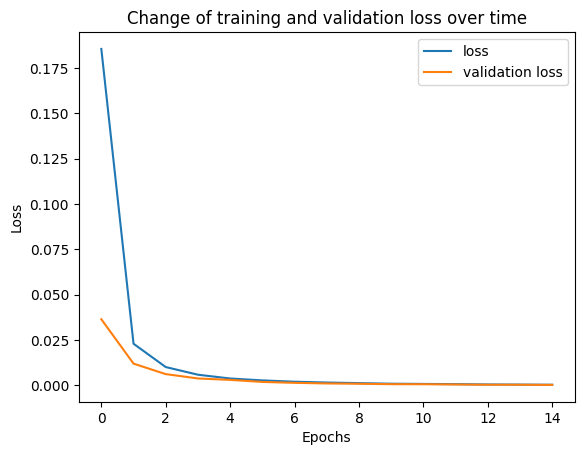

In [10]:
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Change of training and validation loss over time")
plt.show()

# Saving the model

In [11]:
# now = datetime.now()
# formatted_date = now.strftime('%Y%m%d%H%M%S')
# model.save(f'../models/model-{formatted_date}.h5')
# print(f'Model saved: model-{formatted_date}.h5')

## Validation using the test set

In [12]:
result = model.predict(X_test)
result = pd.DataFrame(result)

result['PREDICTION'] = result.apply(lambda x: 0 if x.loc[0] > x.loc[1] else 1, axis=1)

y_test = y_test.reset_index()
y_test['PREDICTION'] = result['PREDICTION']

validation_result = y_test[['PREDICTION', 'HAS_PARODONTITIS']]

94/94 [==============================] - 0s 1ms/step


In [13]:
wrong_prediction = validation_result[validation_result["HAS_PARODONTITIS"] != validation_result['PREDICTION']]
print(f"Predicted wrong: {len(wrong_prediction)}/{len(validation_result)}")

Predicted wrong: 0/3001


## Validation used with seperated data

In [14]:
df_validation = pd.read_csv('../data/patients-validation.csv')

X_validation = df_validation[[
    # 'PATIENT_ID',
    # 'SEX',
    # 'BIRTH_DATE',
    # 'VISIT_DATE',
    # 'TREATING_PROVIDER',
    'BLEEDING_ON_PROBING',
    'NR_OF_POCKET',
    'NR_OF_FURCATION',
    'NR_OF_MOBILITY',
    'TOTAL_LOSS_OF_ATTACHMENT_LEVEL'
]]

y_validation = df_validation[[
    'HAS_PARODONTITIS'
]]

result = model.predict(X_validation)
result = pd.DataFrame(result)

result['PREDICTION'] = result.apply(lambda x: 0 if x.loc[0] > x.loc[1] else 1, axis=1)

y_validation = y_validation.reset_index()
y_validation['PREDICTION'] = result['PREDICTION']

validation_result = y_validation[['PREDICTION', 'HAS_PARODONTITIS']]

313/313 [==============================] - 0s 1ms/step


In [15]:
wrong_prediction = validation_result[validation_result["HAS_PARODONTITIS"] != validation_result['PREDICTION']]
print(f"Predicted wrong: {len(wrong_prediction)}/{len(validation_result)}")

Predicted wrong: 0/10001


# SHAP

In [16]:
shap.initjs()

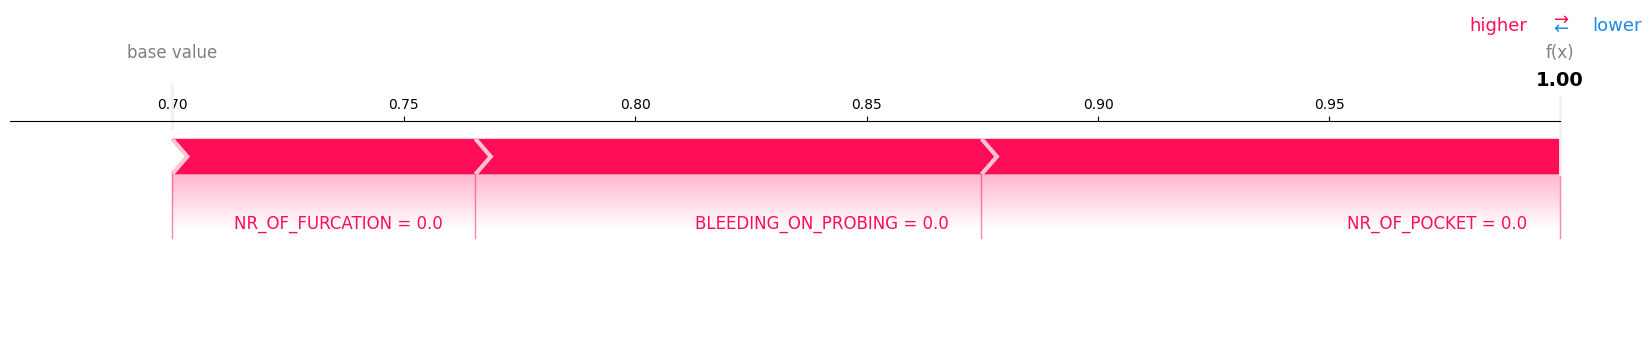

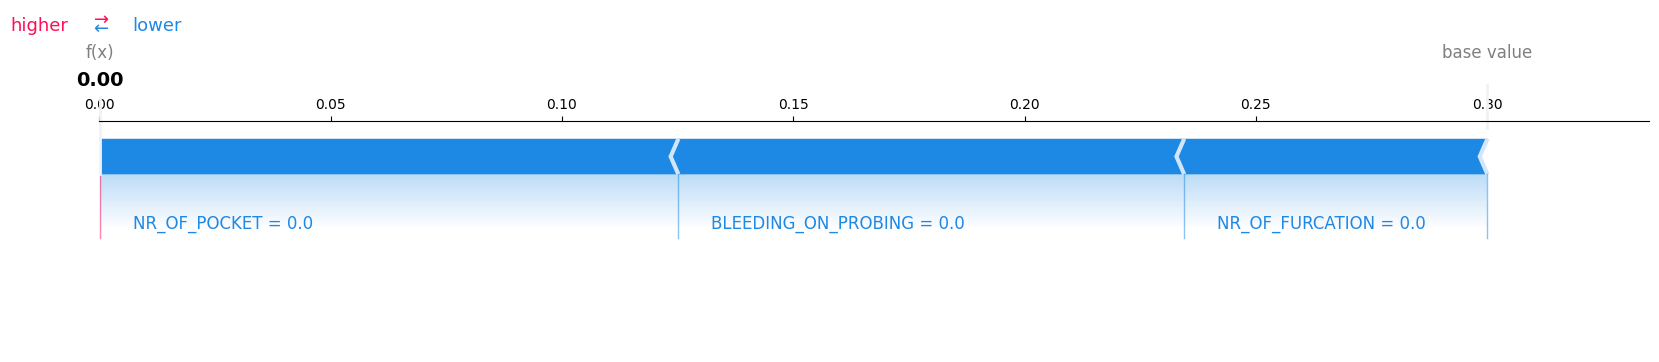

In [17]:
shap_explainer = shap.KernelExplainer(model, X_train[:100])

sample = np.array(X_train.iloc[1])
# sample = np.array([2,2,0,0,1]) # <- playable sample

shap_values = shap_explainer.shap_values(sample)

# Label: has not parodontitis
shap.force_plot(
    shap_explainer.expected_value[0], shap_values[0], sample, matplotlib=True, show=False, plot_cmap=['#77dd77', '#f99191'], feature_names=X_train.columns
)

# Label: has parodontitis
shap.force_plot(
    shap_explainer.expected_value[1], shap_values[1], sample, matplotlib=True, show=False, plot_cmap=['#77dd77', '#f99191'], feature_names=X_train.columns
)

plt.show()